<a href="https://colab.research.google.com/github/robertchoi/BatteryDatasetImplementation/blob/master/%EB%82%B4%EB%B6%80%EC%A0%80%ED%95%AD%EA%B5%AC%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [71]:
df = pd.read_csv('/content/drive/MyDrive/M0000_0009_0019_20170109075822_cell50.csv', encoding='utf8')
df

,Volt,Temp,Resistance
0,4.49,-20,0.466
1,4.49,-20,0.453
2,4.48,-20,0.458
3,4.48,-20,0.458
4,4.47,-20,0.465
...,...,...,...
8967,4.47,-20,0.777
8968,4.45,-20,0.776
8969,4.46,-20,0.777
8970,4.46,-20,0.777


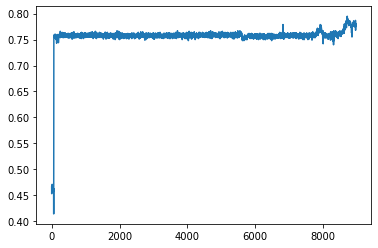

In [39]:
df['Resistance'].plot()

In [72]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scale_cols = ['Volt', 'Temp', 'Resistance']
df_scaled = scaler.fit_transform(df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

print(df_scaled)

          Volt  Temp  Resistance
0     0.937500   0.0    0.136483
1     0.937500   0.0    0.102362
2     0.916667   0.0    0.115486
3     0.916667   0.0    0.115486
4     0.895833   0.0    0.133858
...        ...   ...         ...
8967  0.895833   0.0    0.952756
8968  0.854167   0.0    0.950131
8969  0.875000   0.0    0.952756
8970  0.875000   0.0    0.952756
8971  0.875000   0.0    0.960630

[8972 rows x 3 columns]


In [73]:
TEST_SIZE= 1794

In [74]:
train = df_scaled[:-TEST_SIZE]
test = df_scaled[-TEST_SIZE:]

In [75]:
train

,Volt,Temp,Resistance
0,0.937500,0.0,0.136483
1,0.937500,0.0,0.102362
2,0.916667,0.0,0.115486
3,0.916667,0.0,0.115486
4,0.895833,0.0,0.133858
...,...,...,...
7173,0.854167,0.0,0.900262
7174,0.854167,0.0,0.905512
7175,0.854167,0.0,0.900262
7176,0.854167,0.0,0.900262


In [76]:
def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [77]:
feature_cols = ['Volt', 'Temp']
label_cols = ['Resistance']

train_feature = train
train_label = train[label_cols]
test_feature = test
test_label = test[label_cols]

train_feature, train_label = make_dataset(train_feature, train_label, 20)
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)


test_feature, test_label = make_dataset(test_feature, test_label, 20)
test_feature.shape, test_label.shape

((1774, 20, 3), (1774, 1))

In [78]:
train_feature

array([[[0.9375    , 0.        , 0.13648294],
        [0.9375    , 0.        , 0.1023622 ],
        [0.91666667, 0.        , 0.11548556],
        ...,
        [0.91666667, 0.        , 0.14698163],
        [0.89583333, 0.        , 0.14435696],
        [0.91666667, 0.        , 0.13648294]],

       [[0.9375    , 0.        , 0.1023622 ],
        [0.91666667, 0.        , 0.11548556],
        [0.91666667, 0.        , 0.11548556],
        ...,
        [0.89583333, 0.        , 0.14435696],
        [0.91666667, 0.        , 0.13648294],
        [0.89583333, 0.        , 0.12860892]],

       [[0.91666667, 0.        , 0.11548556],
        [0.91666667, 0.        , 0.11548556],
        [0.89583333, 0.        , 0.13385827],
        ...,
        [0.91666667, 0.        , 0.13648294],
        [0.89583333, 0.        , 0.12860892],
        [0.9375    , 0.        , 0.12860892]],

       ...,

       [[0.875     , 0.        , 0.91338583],
        [0.875     , 0.        , 0.91076115],
        [0.85416667, 0

In [80]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(16, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )
model.add(Dense(1))

In [82]:
model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)
filename = os.path.join('C:/Users/wlsrm/data', 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                    epochs=200, 
                    batch_size=16,
                    validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop, checkpoint])

Epoch 1/200
358/358 [==============================] - 4s 8ms/step - loss: 0.1057 - val_loss: 2.6268e-04

Epoch 00001: val_loss improved from inf to 0.00026, saving model to C:/Users/wlsrm/data/tmp_checkpoint.h5
Epoch 2/200
358/358 [==============================] - 3s 8ms/step - loss: 3.2081e-04 - val_loss: 1.6631e-04

Epoch 00002: val_loss improved from 0.00026 to 0.00017, saving model to C:/Users/wlsrm/data/tmp_checkpoint.h5
Epoch 3/200
358/358 [==============================] - 3s 8ms/step - loss: 5.2463e-04 - val_loss: 1.1387e-04

Epoch 00003: val_loss improved from 0.00017 to 0.00011, saving model to C:/Users/wlsrm/data/tmp_checkpoint.h5
Epoch 4/200
358/358 [==============================] - 3s 8ms/step - loss: 3.8010e-04 - val_loss: 8.9071e-05

Epoch 00004: val_loss improved from 0.00011 to 0.00009, saving model to C:/Users/wlsrm/data/tmp_checkpoint.h5
Epoch 5/200
358/358 [==============================] - 3s 8ms/step - loss: 2.2369e-04 - val_loss: 8.9491e-05

Epoch 00005: val_l

In [83]:
# model.load_weights(filename)

pred = model.predict(test_feature)

In [87]:
test_feature.shape

(1774, 20, 3)

In [84]:
pred

array([[0.89988655],
       [0.90057576],
       [0.89905113],
       ...,
       [0.9319826 ],
       [0.93309855],
       [0.933354  ]], dtype=float32)

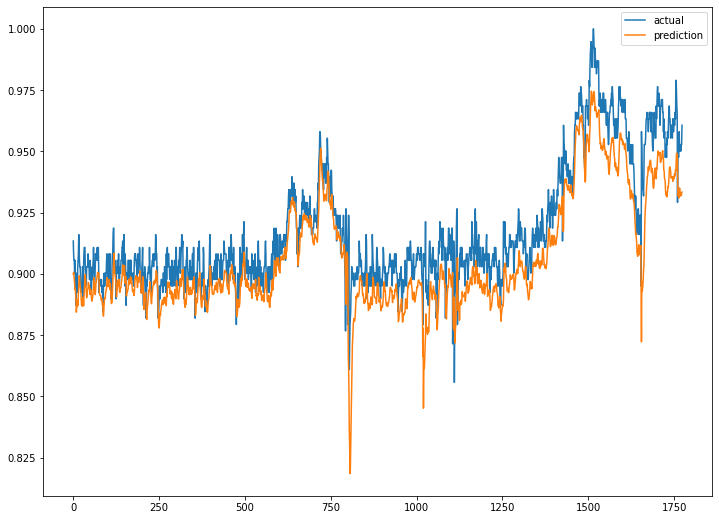

In [85]:
plt.figure(figsize=(12, 9))
plt.plot(test_label, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [88]:
df2 = pd.read_csv('/content/drive/MyDrive/6-4cell6.csv', encoding='utf8')
df2

,Volt,Temp,Resistance
0,2.24,-20,0.355
1,2.24,-20,0.352
2,2.24,-20,0.351
3,2.24,-20,0.353
4,2.24,-20,0.352
...,...,...,...
412,2.29,-20,0.796
413,2.29,-20,0.793
414,2.29,-20,0.795
415,2.29,-20,0.796


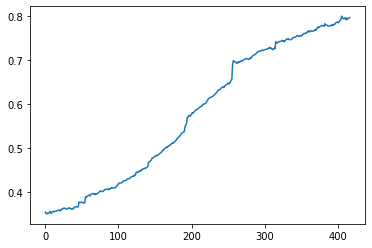

In [89]:
df2['Resistance'].plot()

In [90]:
df_scaled2 = scaler.fit_transform(df2[scale_cols])

df_scaled2 = pd.DataFrame(df_scaled2)
df_scaled2.columns = scale_cols

print(df_scaled2)

         Volt  Temp  Resistance
0    0.166667   0.0    0.008909
1    0.166667   0.0    0.002227
2    0.166667   0.0    0.000000
3    0.166667   0.0    0.004454
4    0.166667   0.0    0.002227
..        ...   ...         ...
412  1.000000   0.0    0.991091
413  1.000000   0.0    0.984410
414  1.000000   0.0    0.988864
415  1.000000   0.0    0.991091
416  1.000000   0.0    0.993318

[417 rows x 3 columns]


In [94]:
test = df_scaled2

In [96]:
test

,Volt,Temp,Resistance
0,0.166667,0.0,0.008909
1,0.166667,0.0,0.002227
2,0.166667,0.0,0.000000
3,0.166667,0.0,0.004454
4,0.166667,0.0,0.002227
...,...,...,...
412,1.000000,0.0,0.991091
413,1.000000,0.0,0.984410
414,1.000000,0.0,0.988864
415,1.000000,0.0,0.991091


In [97]:
test_feature = test
test_label = test[label_cols]

In [98]:
test_feature, test_label = make_dataset(test_feature, test_label, 20)
test_feature.shape, test_label.shape

((397, 20, 3), (397, 1))

In [99]:
pred = model.predict(test_feature)

In [100]:
pred

array([[0.13247663],
       [0.13215828],
       [0.13280743],
       [0.13323396],
       [0.13518584],
       [0.13643372],
       [0.13790557],
       [0.13821754],
       [0.13907814],
       [0.1389811 ],
       [0.13839802],
       [0.1380067 ],
       [0.13829145],
       [0.1397519 ],
       [0.14004302],
       [0.14024618],
       [0.13927472],
       [0.13911295],
       [0.13848631],
       [0.13806358],
       [0.13960037],
       [0.14056742],
       [0.1424945 ],
       [0.14373313],
       [0.14454374],
       [0.14506549],
       [0.14539695],
       [0.1527029 ],
       [0.15670606],
       [0.1593146 ],
       [0.16790146],
       [0.16681266],
       [0.16492265],
       [0.1630862 ],
       [0.16260937],
       [0.16170937],
       [0.17022467],
       [0.1749222 ],
       [0.17930639],
       [0.18278602],
       [0.1856868 ],
       [0.18820173],
       [0.18852064],
       [0.19005203],
       [0.19229725],
       [0.19434962],
       [0.1956434 ],
       [0.196

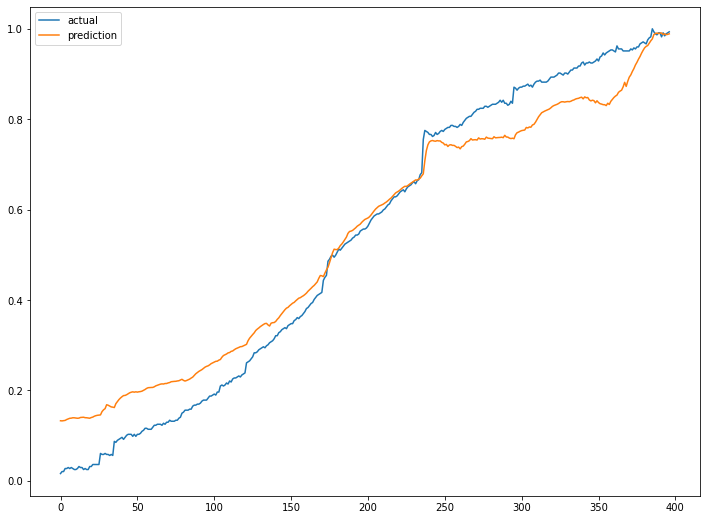

In [101]:
plt.figure(figsize=(12, 9))
plt.plot(test_label, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()